<a href="https://colab.research.google.com/github/RolandTapie/Data_Projects/blob/main/Data_science/Bank/Bank_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Fonction**

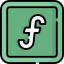

In [4]:
def summary(liste,section,libelle,valeur):
  liste.append([len(liste)+1,section,libelle,valeur])
  return (liste)

def print_summary(data):
  headers = data[0]
  table_data = data[1:]
  titre="RESULTATS: analyses et Modélisation"
  titre=titre.center(100,"=")
  print("*"* len(titre))
  print(titre)
  print("*"* len(titre))
  print(tabulate(table_data, headers, tablefmt="grid"))

  table_str = titre + "\n" +tabulate(table_data, headers, tablefmt="grid")

  output_file = "/content/drive/My Drive/colab_table_a4_format.txt"

  # Write the formatted table to a .txt file
  with open(output_file, "w") as file:
      file.write(table_str)

  print(f"Table saved to {output_file}")


**Import des packages**

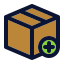

In [5]:
#!pip install nxviz
!pip install fpdf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
#import nxviz as nv
import missingno as msno
from itertools import combinations
from tabulate import tabulate
from google.colab import drive
import os
from fpdf import FPDF

from scipy.stats import iqr, shapiro
from sklearn.metrics import mean_squared_error, r2_score,roc_curve, auc
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, recall_score,f1_score,accuracy_score,precision_score
import seaborn as sns
import statsmodels.api as sm
from statsmodels.api import qqplot
import numpy as np


**Configuration**

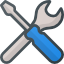

In [6]:
resume=[]
resume=summary(resume,"Section","libelle","information")


predictions=[]
recall={}
accuracy={}
f1score={}
precision={}

alpha=0.05
fraction=0.2
seed=55
corr_limit=0.4
fold=5


modeles={
    "logreg":LogisticRegression(solver='lbfgs', max_iter=100),
    "knn":KNeighborsClassifier(n_neighbors=5),
    "tree":DecisionTreeClassifier(random_state=0)
    }

modeles_grid={
    "logreg":{
        'C': [0.1, 1, 10, 100],  # Force de régularisation (inverse de λ)
        'penalty': ['l1', 'l2', 'elasticnet', None],  # Types de régularisation
        'solver': ['lbfgs'],  # Algorithmes d'optimisation
        'l1_ratio': [0, 0.5, 1]  # Utilisé uniquement avec elasticnet},
            },
    "knn":{
        'n_neighbors': [3, 5, 7, 9],          # Nombre de voisins
        'weights': ['uniform', 'distance'],   # Poids uniformes ou inversement proportionnels à la distance
        'metric': ['euclidean', 'manhattan', 'minkowski'],  # Type de distance
        'p': [1, 2]  # Valeur de 'p' pour la distance Minkowski (1 = Manhattan, 2 = Euclidienne)},
          },
    "tree":{
        'criterion': ['gini', 'entropy'],       # Fonction pour mesurer la qualité du split
        'splitter': ['best', 'random'],         # Stratégie pour choisir la variable de split
        'max_depth': [3, 5, 10, None],          # Profondeur maximale de l'arbre
        'min_samples_split': [2, 5, 10],        # Nombre minimum d'échantillons pour diviser un nœud
        'min_samples_leaf': [1, 2, 4],          # Nombre minimum d'échantillons dans une feuille
        'max_features': [None, 'auto', 'sqrt', 'log2']  # Nombre maximum de caractéristiques pour les splits}
      }
}
validation_croisee=False


file_path="https://raw.githubusercontent.com/RolandTapie/Data_Projects/refs/heads/main/Data_science/Datasets/titanic_data_simplified.csv"
file_path="https://raw.githubusercontent.com/RolandTapie/Data_Projects/refs/heads/main/Data_science/Datasets/Raisin_Dataset.csv"
file_path="https://raw.githubusercontent.com/RolandTapie/Data_Projects/refs/heads/main/Data_science/Datasets/bank_cleaned.csv"


cible="Survived"
cible="Class"
cible="response_binary"



resume=summary(resume,"Configuration","Seuil d'acceptabilité des hypothèses  : ",alpha)
resume=summary(resume,"Configuration","Fraction de la base de test : ",fraction)
resume=summary(resume,"Configuration","Seed : ",seed)
resume=summary(resume,"Configuration","Limite de corrélation : ",corr_limit)
resume=summary(resume,"Configuration","Modele : ",modeles)
resume=summary(resume,"Dataset","Chemin du fichier : ",file_path)
resume=summary(resume,"Dataset","Cible : ",cible)

**Montage du drive**

In [7]:
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


**Lecture du dataset**

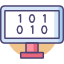

In [8]:
df = pd.read_csv(file_path)

resume=summary(resume,"Dataset","Path",file_path)

In [9]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40841 entries, 0 to 40840
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       40841 non-null  int64  
 1   age              40841 non-null  int64  
 2   job              40841 non-null  object 
 3   marital          40841 non-null  object 
 4   education        40841 non-null  object 
 5   default          40841 non-null  object 
 6   balance          40841 non-null  int64  
 7   housing          40841 non-null  object 
 8   loan             40841 non-null  object 
 9   day              40841 non-null  int64  
 10  month            40841 non-null  object 
 11  duration         40841 non-null  float64
 12  campaign         40841 non-null  int64  
 13  pdays            40841 non-null  int64  
 14  previous         40841 non-null  int64  
 15  poutcome         40841 non-null  object 
 16  response         40841 non-null  object 
 17  response_bin

**Renommage des colonnes**

In [10]:

feat=['age', 'job', 'marital', 'education', 'default','balance', 'housing', 'loan', 'day', 'month', 'duration', 'campaign','pdays', 'previous', 'poutcome', 'response_binary']
feat=['age', 'balance','duration', 'campaign','pdays','loan']
one_hot_enconding=["job","marital","education","default","housing","loan","month","poutcome"]
one_hot_enconding=['loan']


**Définir la cible**

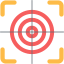

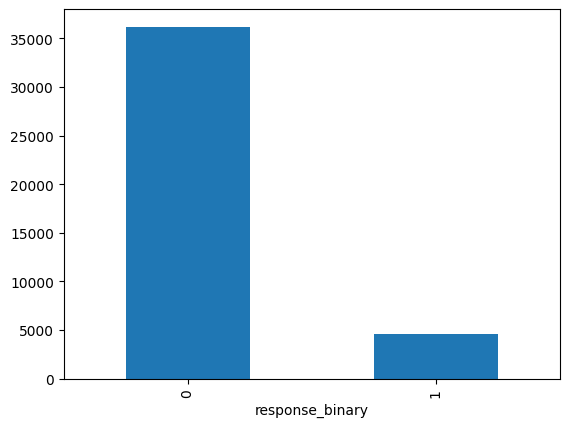

2


In [11]:
df_cible=df[cible].value_counts()
df_cible.plot(kind="bar")
plt.show()
print(len(df_cible))
if (len(df_cible)==2):
  resume=summary(resume,"Dataset","Nature cible", "Cible binaire -> Classification")
elif (len(df_cible)>2):
  resume=summary(resume,"Dataset","Nature cible", "Cible non binaire -> Régression")
else:
  resume=summary(resume,"Dataset","Nature cible", "Vérifier la cible")
  raise ValueError("Vérifier la cible")

**Description du dataset**

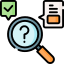

In [12]:
df.describe()
resume=summary(resume,"Dataset","taille", str(len(df)) + " observations")

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40841 entries, 0 to 40840
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       40841 non-null  int64  
 1   age              40841 non-null  int64  
 2   job              40841 non-null  object 
 3   marital          40841 non-null  object 
 4   education        40841 non-null  object 
 5   default          40841 non-null  object 
 6   balance          40841 non-null  int64  
 7   housing          40841 non-null  object 
 8   loan             40841 non-null  object 
 9   day              40841 non-null  int64  
 10  month            40841 non-null  object 
 11  duration         40841 non-null  float64
 12  campaign         40841 non-null  int64  
 13  pdays            40841 non-null  int64  
 14  previous         40841 non-null  int64  
 15  poutcome         40841 non-null  object 
 16  response         40841 non-null  object 
 17  response_bin

**Traiter le type des données**

In [14]:
for col in df.columns:
  if "Unnamed" in col:
    df=df.drop(col,axis=1)
  if "Emoji" in col:
    df=df.drop(col,axis=1)

colonnes=df.columns.tolist()

print("Les champs du Dataset")
print(colonnes)
compteur=0
for col in colonnes:
  if df[col].dtype=="object":
    df[col]=df[col].astype("category")
    compteur+=1

    print(f'les données du champ {col} de type {df[col].dtype} ont été changées en type category')
    print('\n')
    print('Avec les valeurs ci-dessous:')
    print('\n')
    print(df[col].unique())
    print('\n')
resume=summary(resume,"Dataset","Nombre de champs de type object tranformés en category",compteur)

liste_cat=[col for col in df.columns if df[col].dtype=="category"]

resume=summary(resume,"Dataset","Nombre de champs de type category",compteur)
liste_float_int=[col for col in df.columns if ((df[col].dtype=="int64")|(df[col].dtype=="float64"))]

print("*"*100)
print('la liste des champs de type float ou int')
print (liste_float_int)
resume=summary(resume,"Dataset","champs de type float ou int",(liste_float_int))
print("*"*100)
print('la liste des champs de type category')
print (liste_cat)
resume=summary(resume,"Dataset","champs de type category",(liste_cat))

Les champs du Dataset
['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'response', 'response_binary']
les données du champ job de type category ont été changées en type category


Avec les valeurs ci-dessous:


['management', 'technician', 'entrepreneur', 'retired', 'admin.', ..., 'self-employed', 'unemployed', 'housemaid', 'student', 'other']
Length: 12
Categories (12, object): ['admin.', 'blue-collar', 'entrepreneur', 'housemaid', ..., 'services',
                          'student', 'technician', 'unemployed']


les données du champ marital de type category ont été changées en type category


Avec les valeurs ci-dessous:


['married', 'single', 'divorced']
Categories (3, object): ['divorced', 'married', 'single']


les données du champ education de type category ont été changées en type category


Avec les valeurs ci-dessous:


['tertiary', 'secondary', 'primary']
Categories (3, o

**Vérification des enrigistrements nulls**

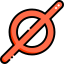

In [15]:
df.isna().any().sum()
resume=summary(resume,"Dataset","Nombre de valeurs nulles",df.isna().any().sum())

**Vérification des doublons**

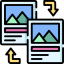

In [16]:
df.duplicated().sum()
resume=summary(resume,"Dataset","Nombre de doublons",df.duplicated().sum())

<Axes: >

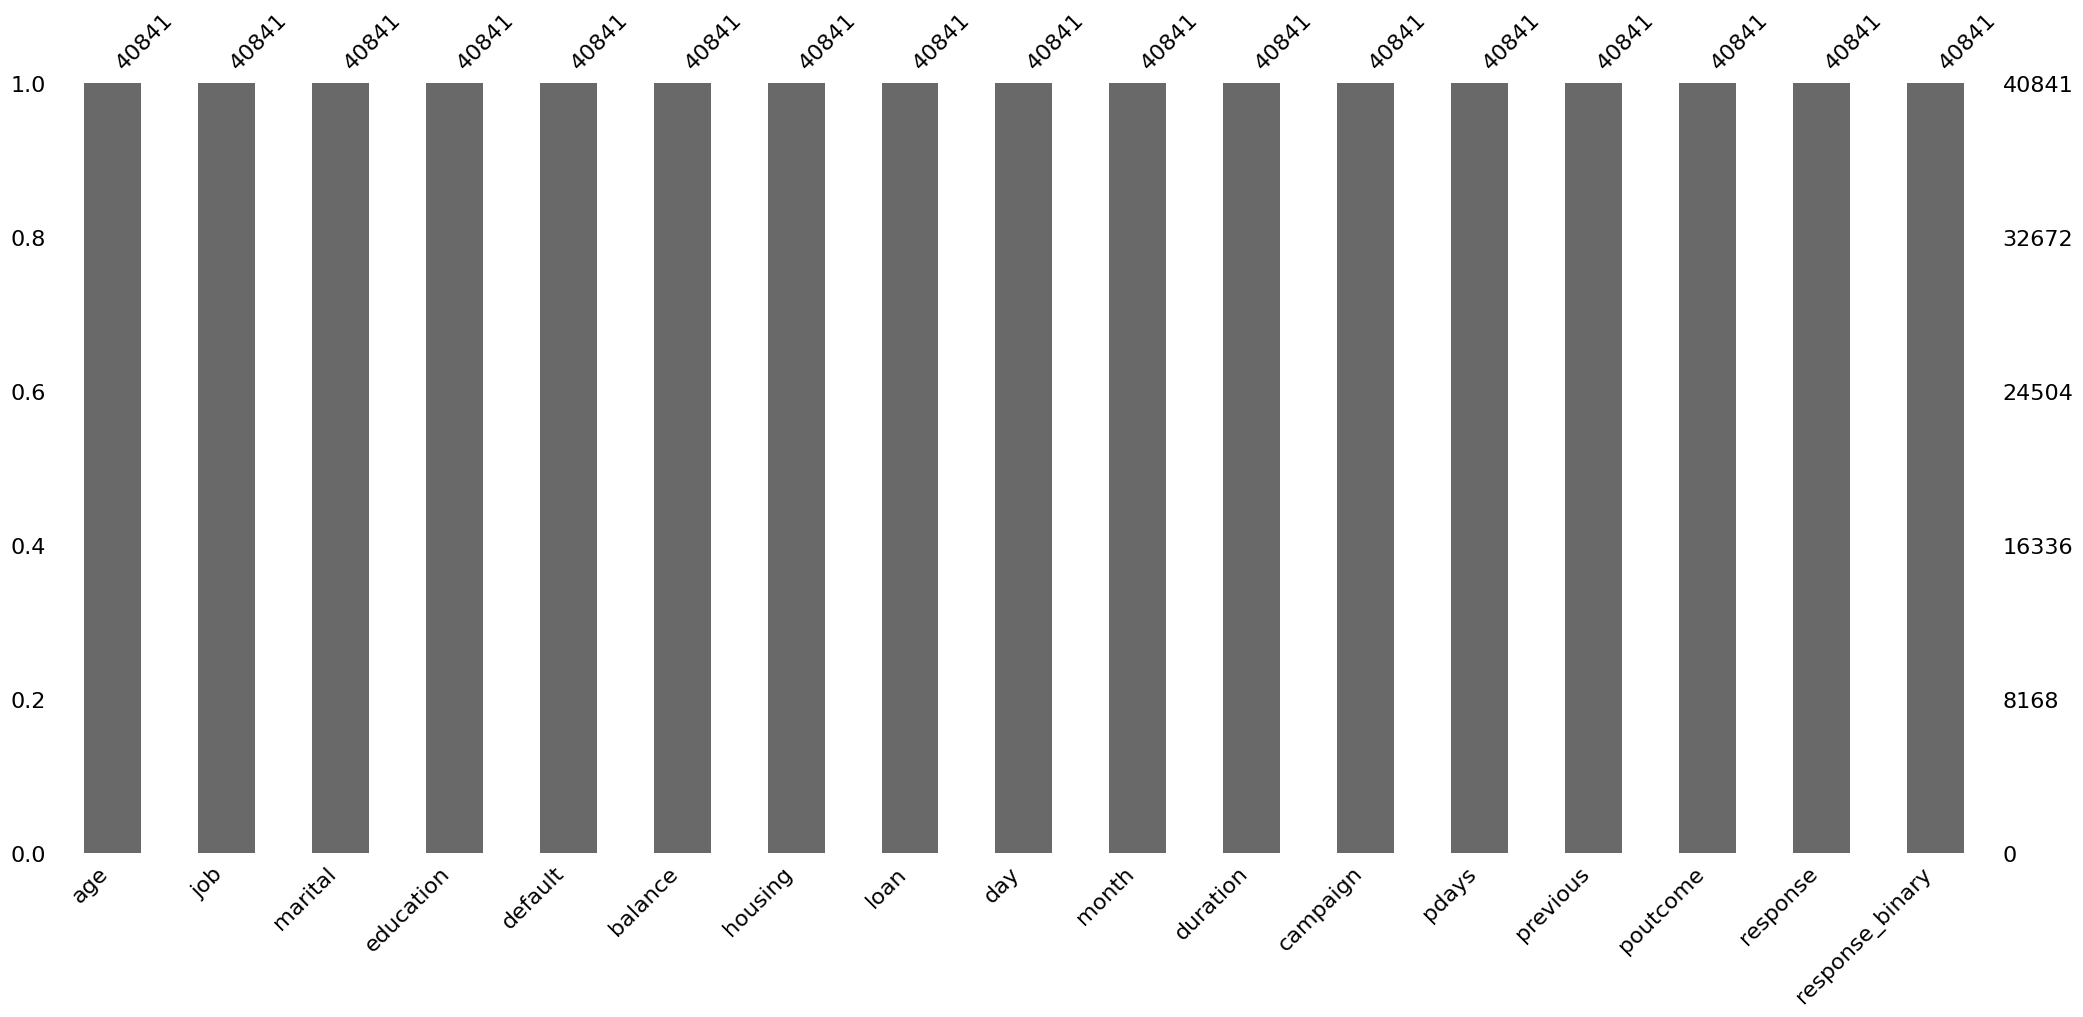

In [17]:
msno.bar(df)

<Axes: >

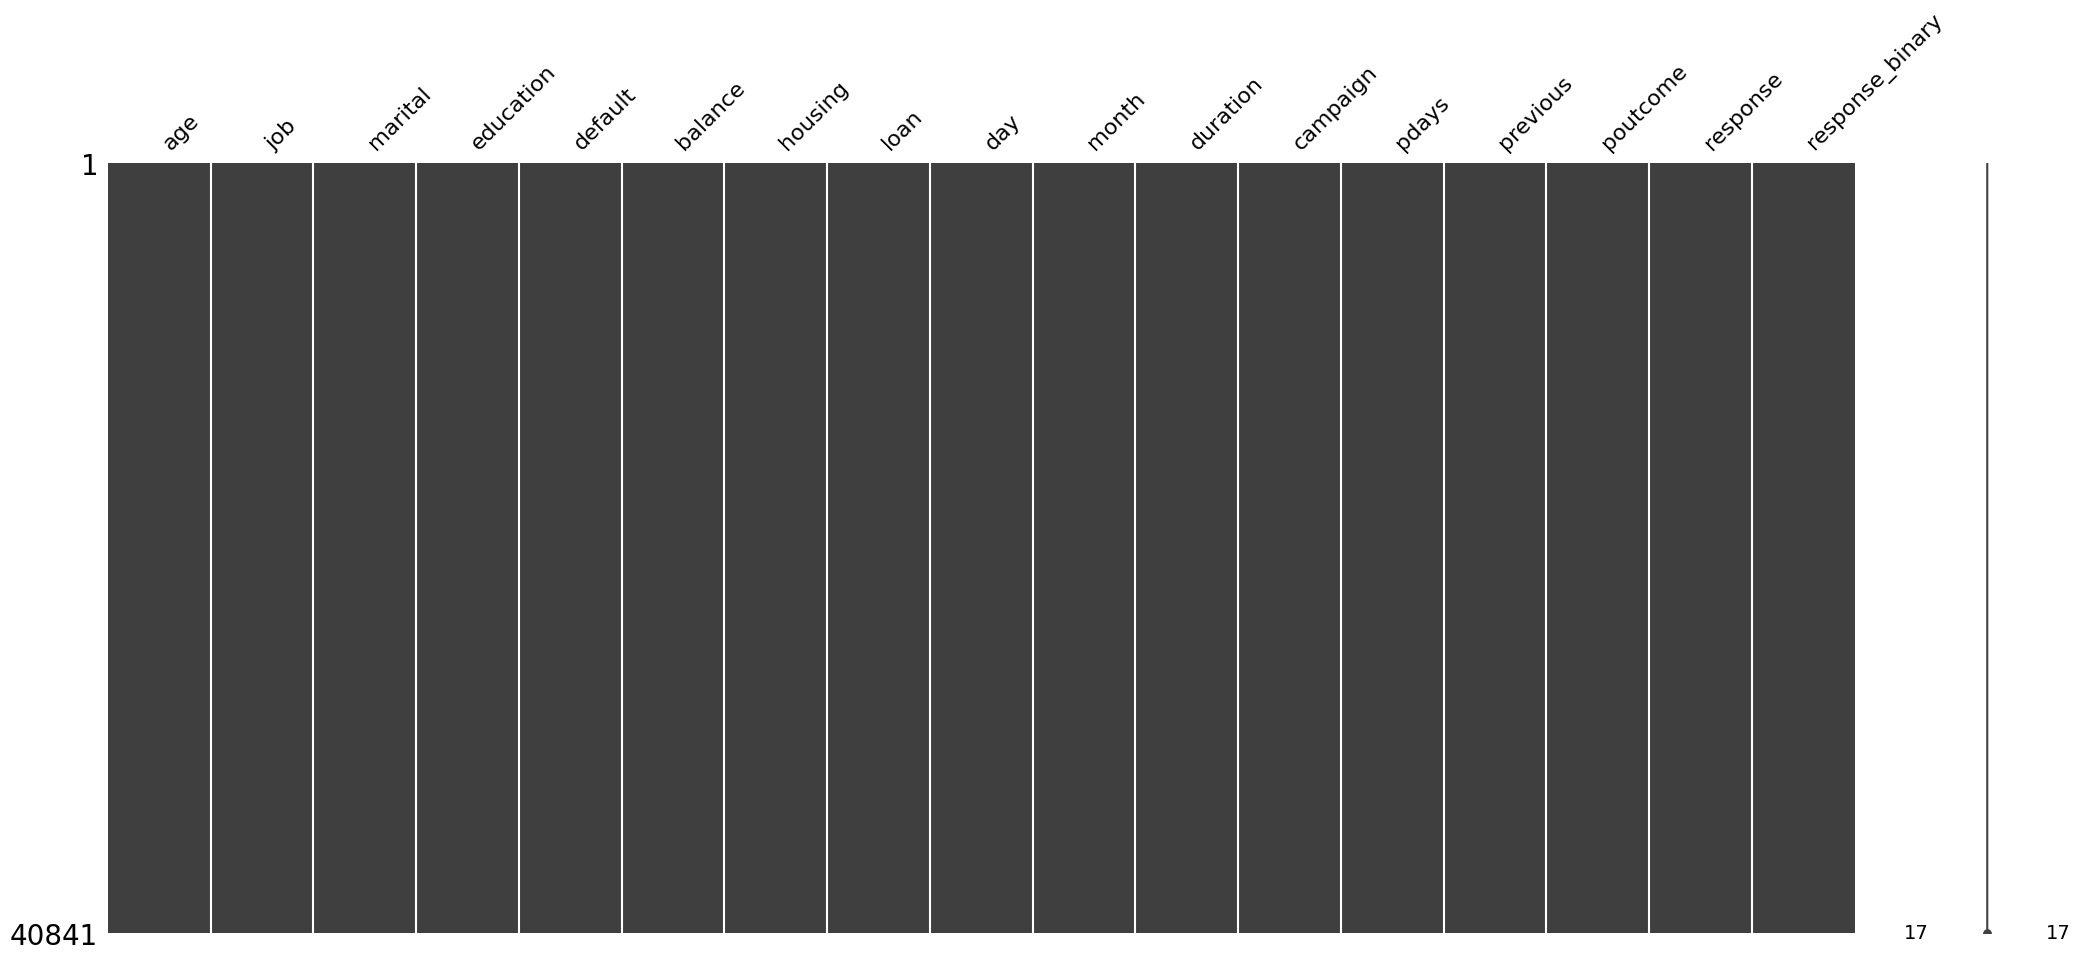

In [18]:
msno.matrix(df)


/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:309: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))
/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:309: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))


<Axes: >

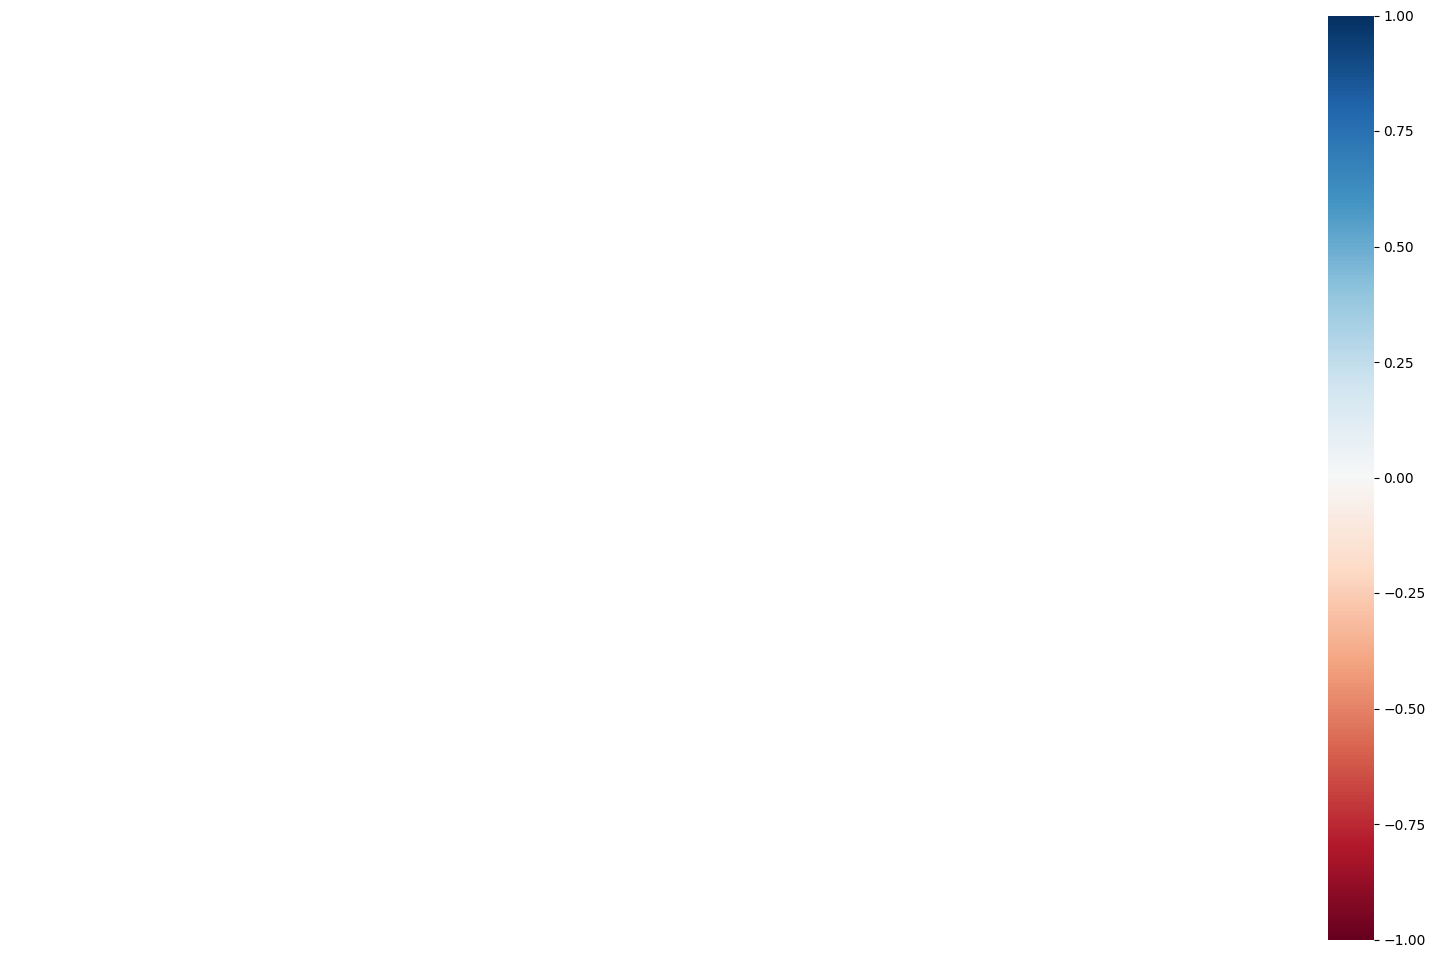

In [19]:
msno.heatmap(df)

/usr/local/lib/python3.10/dist-packages/scipy/cluster/hierarchy.py:2821: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([dvw, 0])


<Axes: >

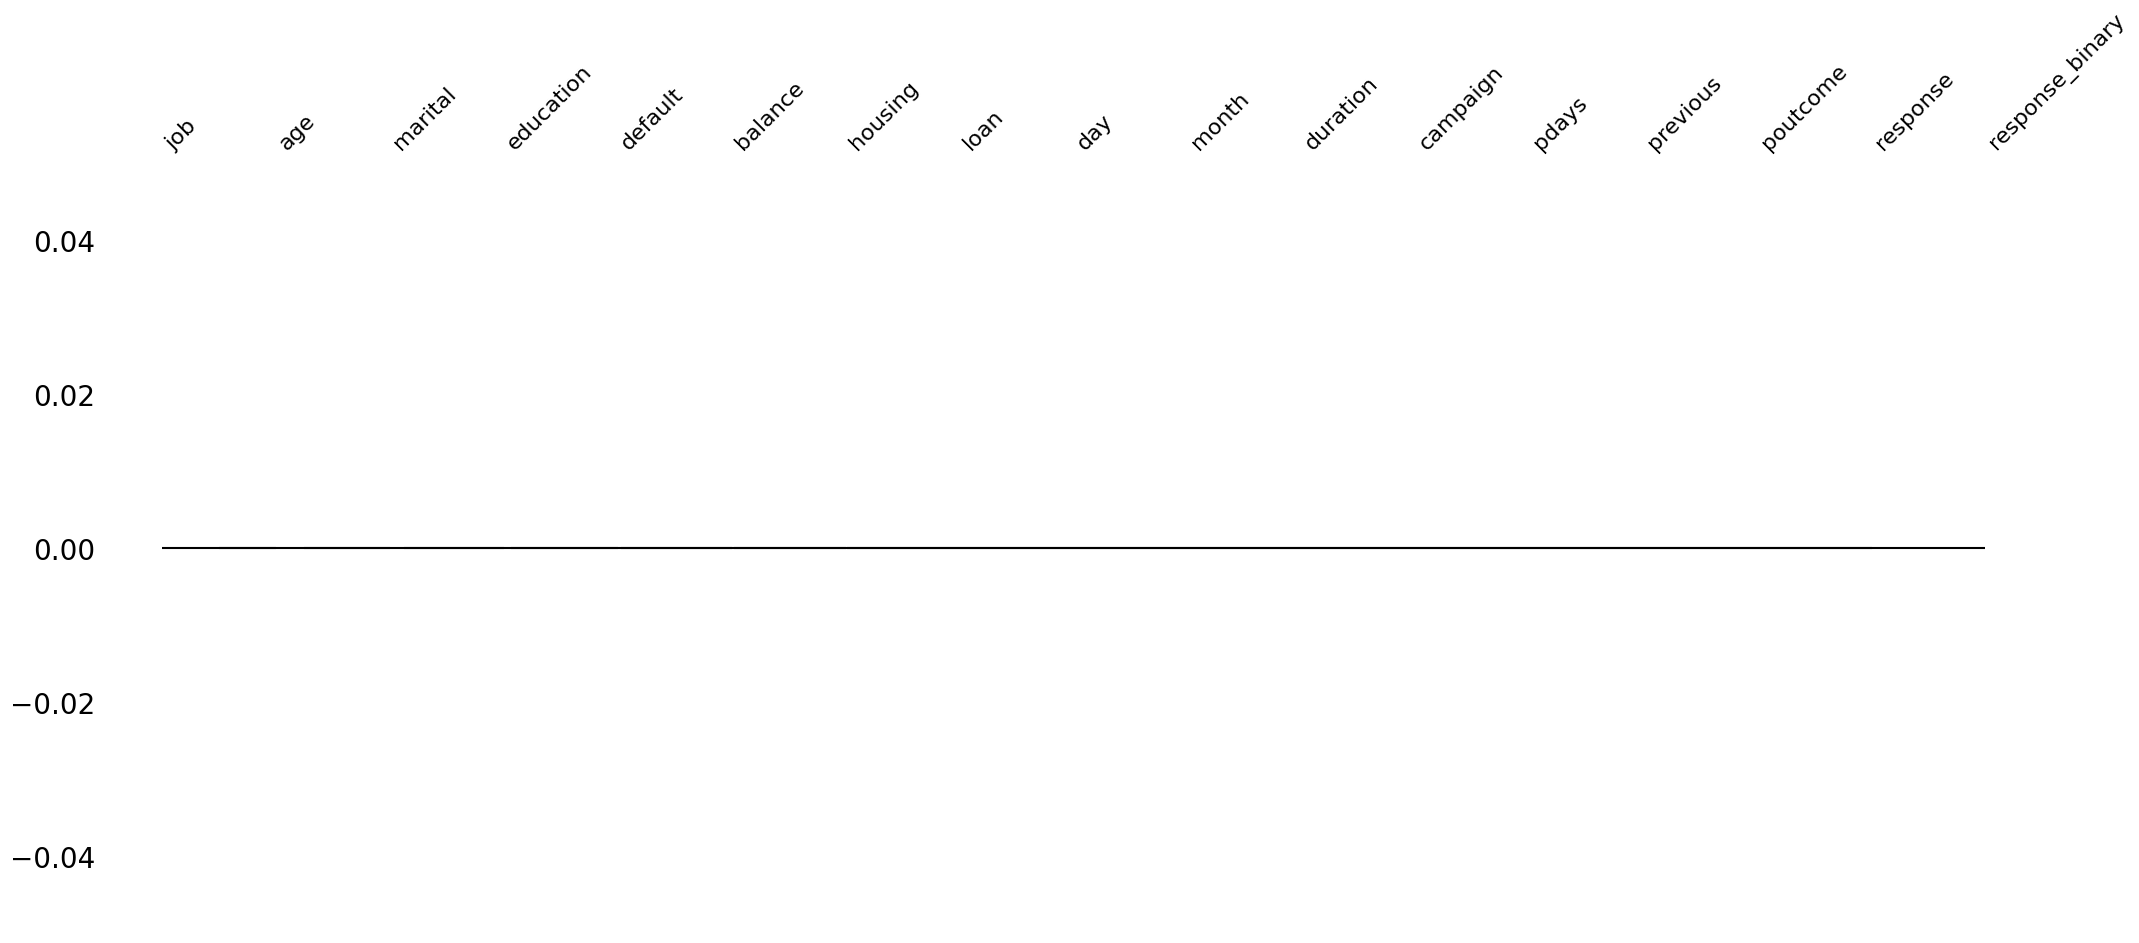

In [20]:
msno.dendrogram(df)

In [21]:
# Supprimer les lignes où toutes les valeurs sont manquantes
df= df.dropna(how='all')

# **EDA**

**Analyse des données catégorielles**

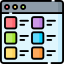

<ipython-input-22-3be22614850c>:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = df.groupby([col, cible]).size().reset_index(name='count')


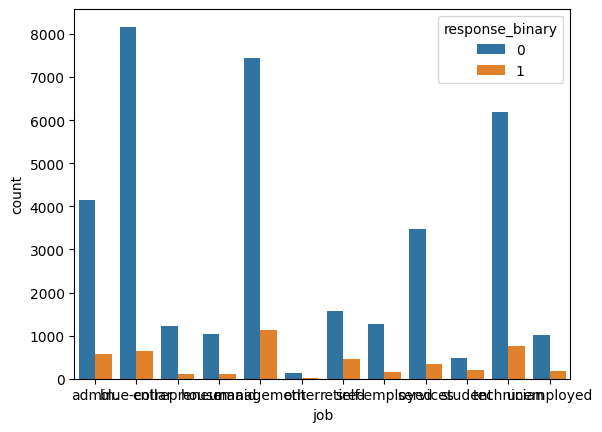

****************************************************************************************************
job
blue-collar      0.22
management       0.21
technician       0.17
admin.           0.12
services         0.09
retired          0.05
self-employed    0.04
entrepreneur     0.03
unemployed       0.03
housemaid        0.03
student          0.02
other            0.00
Name: proportion, dtype: float64


<ipython-input-22-3be22614850c>:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = df.groupby([col, cible]).size().reset_index(name='count')


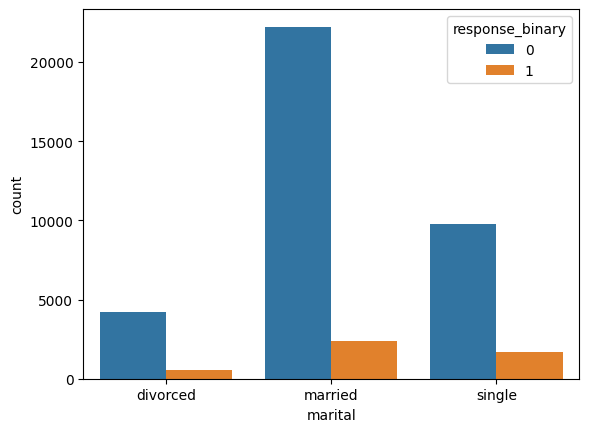

****************************************************************************************************
marital
married     0.60
single      0.28
divorced    0.12
Name: proportion, dtype: float64


<ipython-input-22-3be22614850c>:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = df.groupby([col, cible]).size().reset_index(name='count')


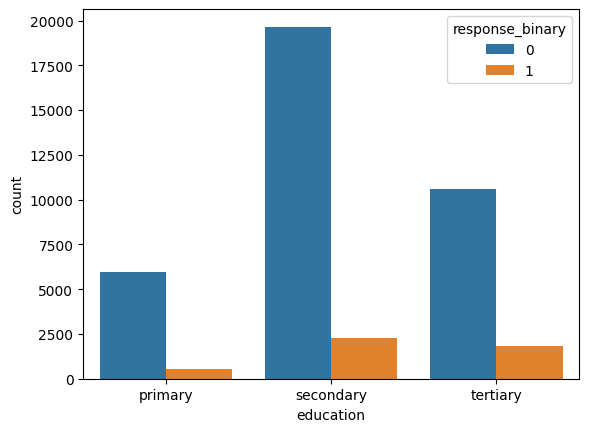

****************************************************************************************************
education
secondary    0.54
tertiary     0.30
primary      0.16
Name: proportion, dtype: float64


<ipython-input-22-3be22614850c>:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = df.groupby([col, cible]).size().reset_index(name='count')


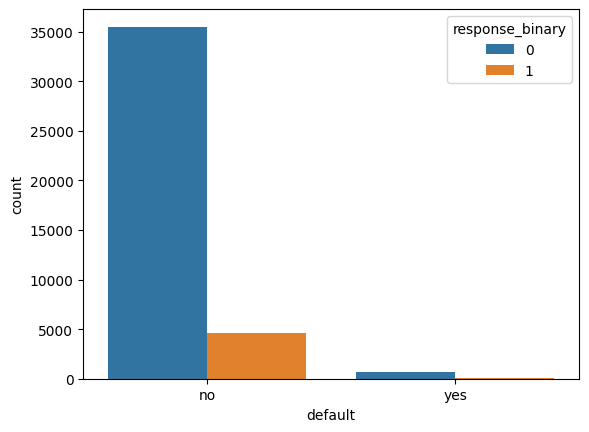

****************************************************************************************************
default
no     0.98
yes    0.02
Name: proportion, dtype: float64


<ipython-input-22-3be22614850c>:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = df.groupby([col, cible]).size().reset_index(name='count')


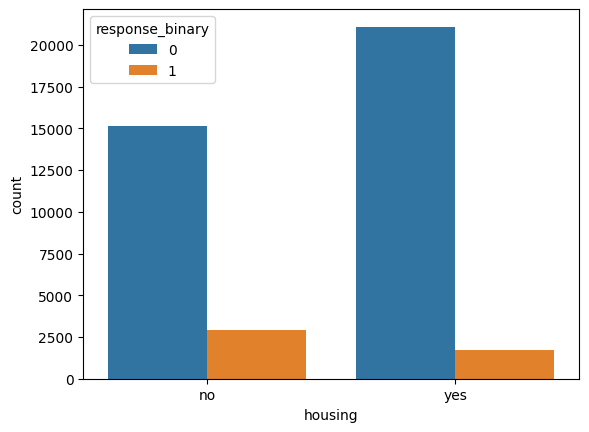

****************************************************************************************************
housing
yes    0.56
no     0.44
Name: proportion, dtype: float64


<ipython-input-22-3be22614850c>:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = df.groupby([col, cible]).size().reset_index(name='count')


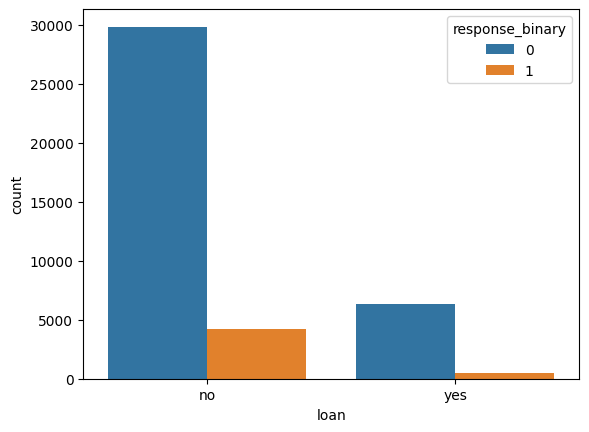

****************************************************************************************************
loan
no     0.83
yes    0.17
Name: proportion, dtype: float64


<ipython-input-22-3be22614850c>:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = df.groupby([col, cible]).size().reset_index(name='count')


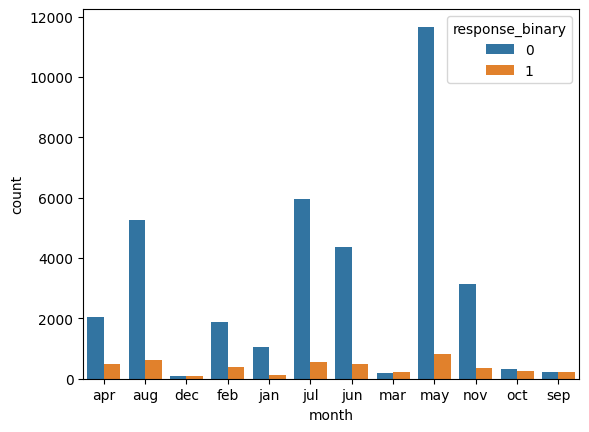

****************************************************************************************************
month
may    0.31
jul    0.16
aug    0.14
jun    0.12
nov    0.09
apr    0.06
feb    0.06
jan    0.03
oct    0.01
sep    0.01
mar    0.01
dec    0.00
Name: proportion, dtype: float64


<ipython-input-22-3be22614850c>:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = df.groupby([col, cible]).size().reset_index(name='count')


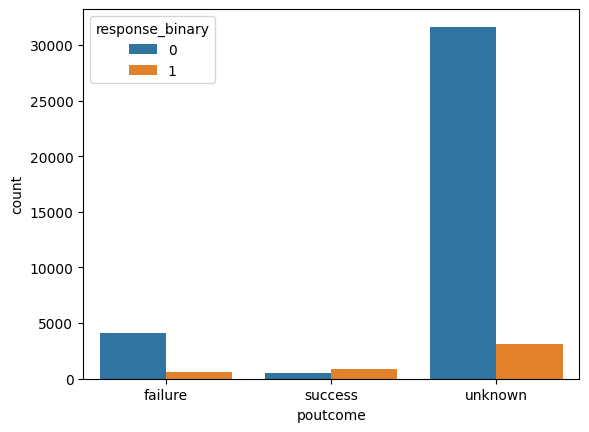

****************************************************************************************************
poutcome
unknown    0.85
failure    0.11
success    0.03
Name: proportion, dtype: float64


<ipython-input-22-3be22614850c>:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = df.groupby([col, cible]).size().reset_index(name='count')


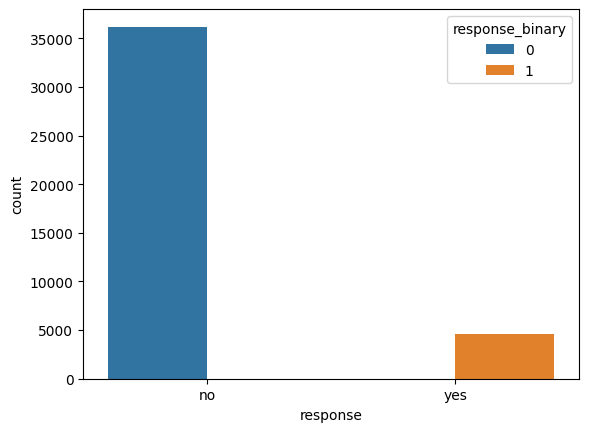

****************************************************************************************************
response
no     0.89
yes    0.11
Name: proportion, dtype: float64


In [22]:
df_cat=df[liste_cat]
analyse=""
for col in liste_cat:
  #print(df_cat[col].value_counts(normalize=True))
  analyse=analyse+col+'\n'
  analyse=analyse+("*"*10)+'\n'
  analyse=analyse+str(df_cat[col].value_counts(normalize=True).round(2))+'\n'
  #df_cat[col].value_counts(normalize=True).plot(kind='bar')

  counts = df.groupby([col, cible]).size().reset_index(name='count')

  sns.barplot(data=counts, x=col, y='count', hue=cible)
  plt.show()
  print("*"*100)
  print(df_cat[col].value_counts(normalize=True).round(2))
resume=summary(resume,"EDA","Analyse des données catégorielles",analyse)

**Vérifications des distributions**

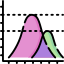



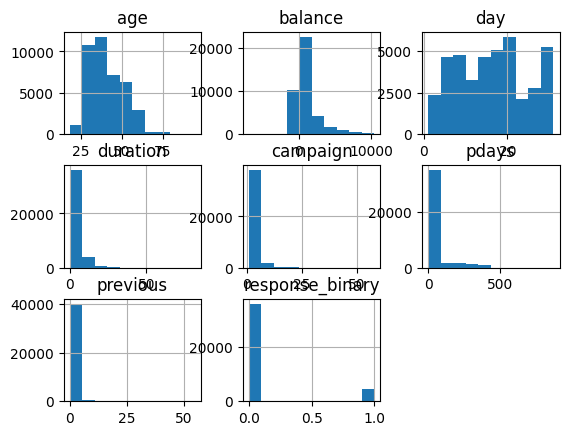

In [23]:
df_num=df[liste_float_int]
df_num.hist()
plt.show()

Test sur la normalité des données numériques

/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 40841.
  res = hypotest_fun_out(*samples, **kwds)


Vérification visuelle pour le champ age
age 0.96 0.0
Vérification visuelle pour le champ balance
balance 0.711 0.0
Vérification visuelle pour le champ day
day 0.96 0.0
Vérification visuelle pour le champ duration
duration 0.722 0.0
Vérification visuelle pour le champ campaign
campaign 0.554 0.0
Vérification visuelle pour le champ pdays
pdays 0.422 0.0
Vérification visuelle pour le champ previous
previous 0.3 0.0
Vérification visuelle pour le champ response_binary
response_binary 0.368 0.0


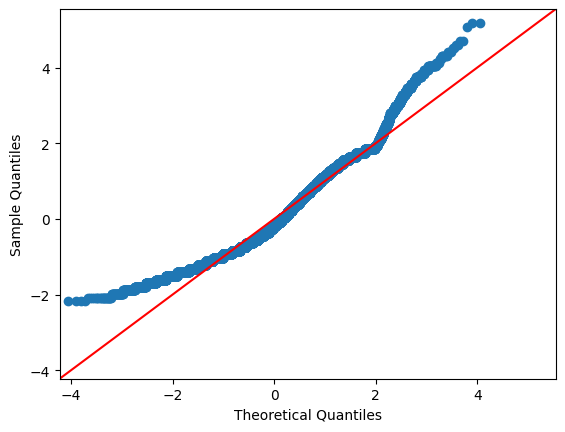

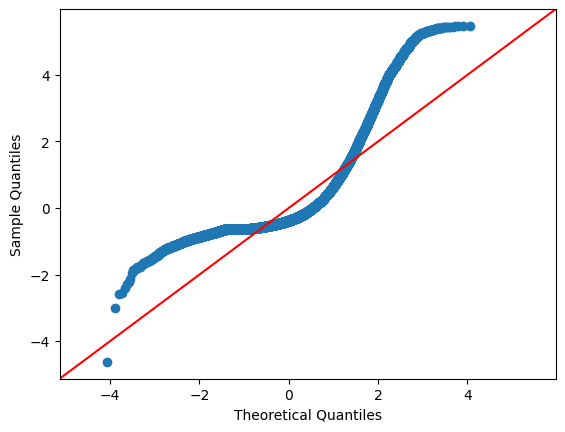

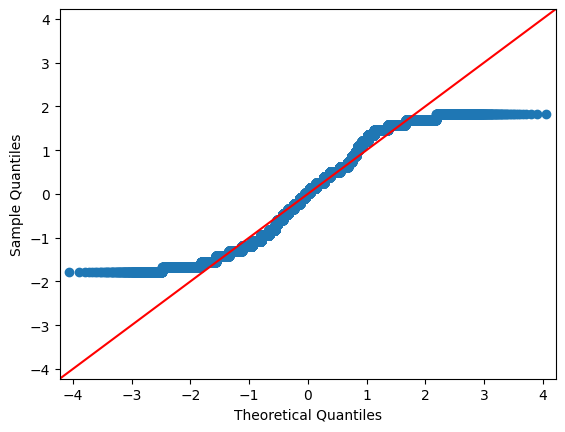

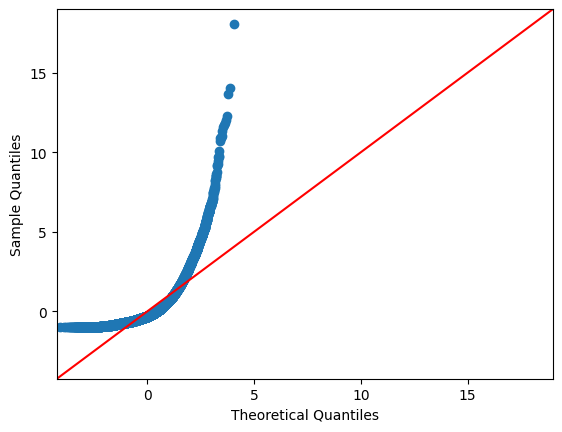

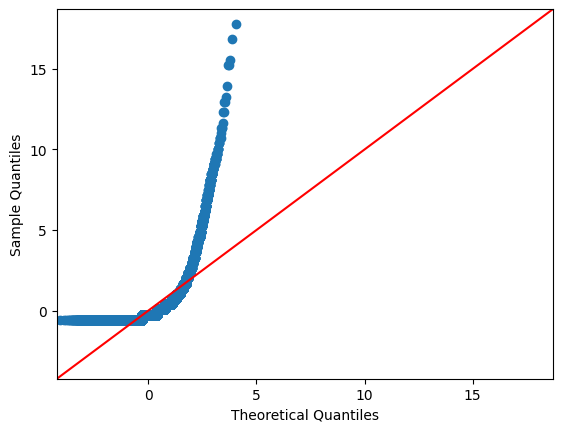

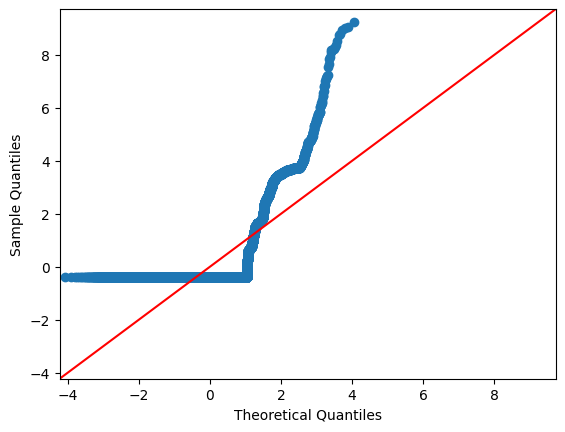

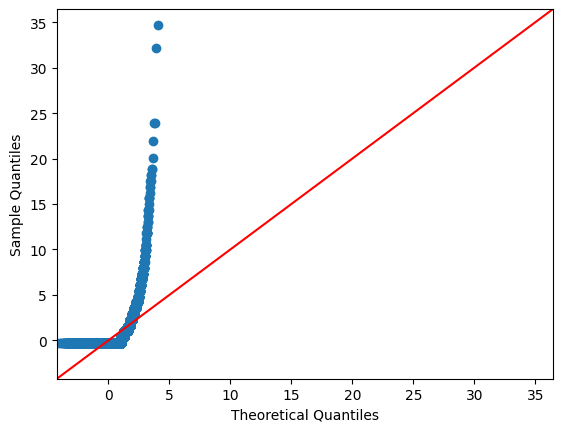

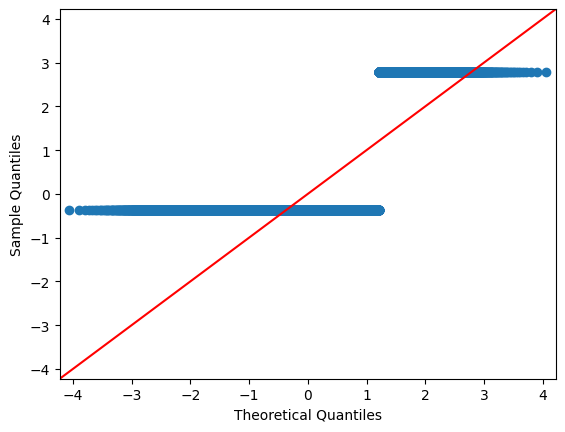

In [24]:

liste_norm=""
for col in liste_float_int:
  stats, p_value = shapiro(df[col])
  stats=round(stats,3)
  p_value=round(p_value,3)
  print(f"Vérification visuelle pour le champ {col}")
  qqplot(df[col], fit=True, line="45")
  if p_value>alpha:
    liste_norm=liste_norm+col+f" : p_value ({p_value} > alpha ({alpha})) Non rejet de H0 > les données suivent une distribution normale"+'\n'
  else:
    liste_norm=liste_norm+col+f" : p_value ({p_value} < alpha ({alpha})) Rejet de H0 > les données ne suivent pas une distribution normale"+'\n'
  print(col,stats, p_value)

resume=summary(resume,"EDA","Distribution normale des données (Test de Shapiro Wilk)",f"Mise en place des hypothèses (alpha) = {(alpha)}:" +"\n" \
               + "H0 > (les données suivent une distribution normale)" +"\n"+ "H1 > (les données ne suivent pas une distribution normale) \n"\
               +"\n"\
               + liste_norm)

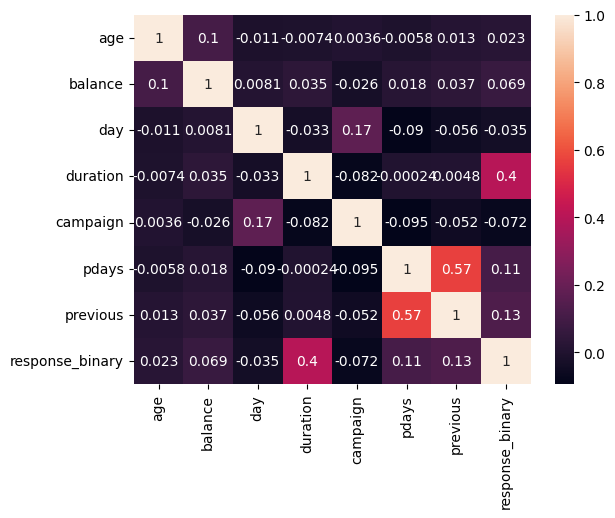

****************************************************************************************************
Liste des corrélations à analyser
****************************************************************************************************
duration > response_binary : 0.401
pdays > previous : 0.568


In [25]:
df_corr=df_num.corr()
sns.heatmap(df_corr,annot=True)
plt.show()
liste=[]
corr_check=[]
liste_corr=""
for i in range(len(df_corr)):
  for j in range(len(df_corr)):
    if (abs(df_corr.iloc[i,j])>=corr_limit)&(i<j):
        corr_check.append((str(df_corr.columns[i])+ " > " + str(df_corr.columns[j])+ " : " + str(round(df_corr.iloc[i,j],3))))
        liste_corr=liste_corr+str(df_corr.columns[i])+ " > " + str(df_corr.columns[j])+ " : " + str(round(df_corr.iloc[i,j],3))+'\n'
print("*"*100)
print("Liste des corrélations à analyser")
print("*"*100)
for cor in corr_check:
  print(cor)

resume=summary(resume,"EDA","corrélations à analyser",(liste_corr))

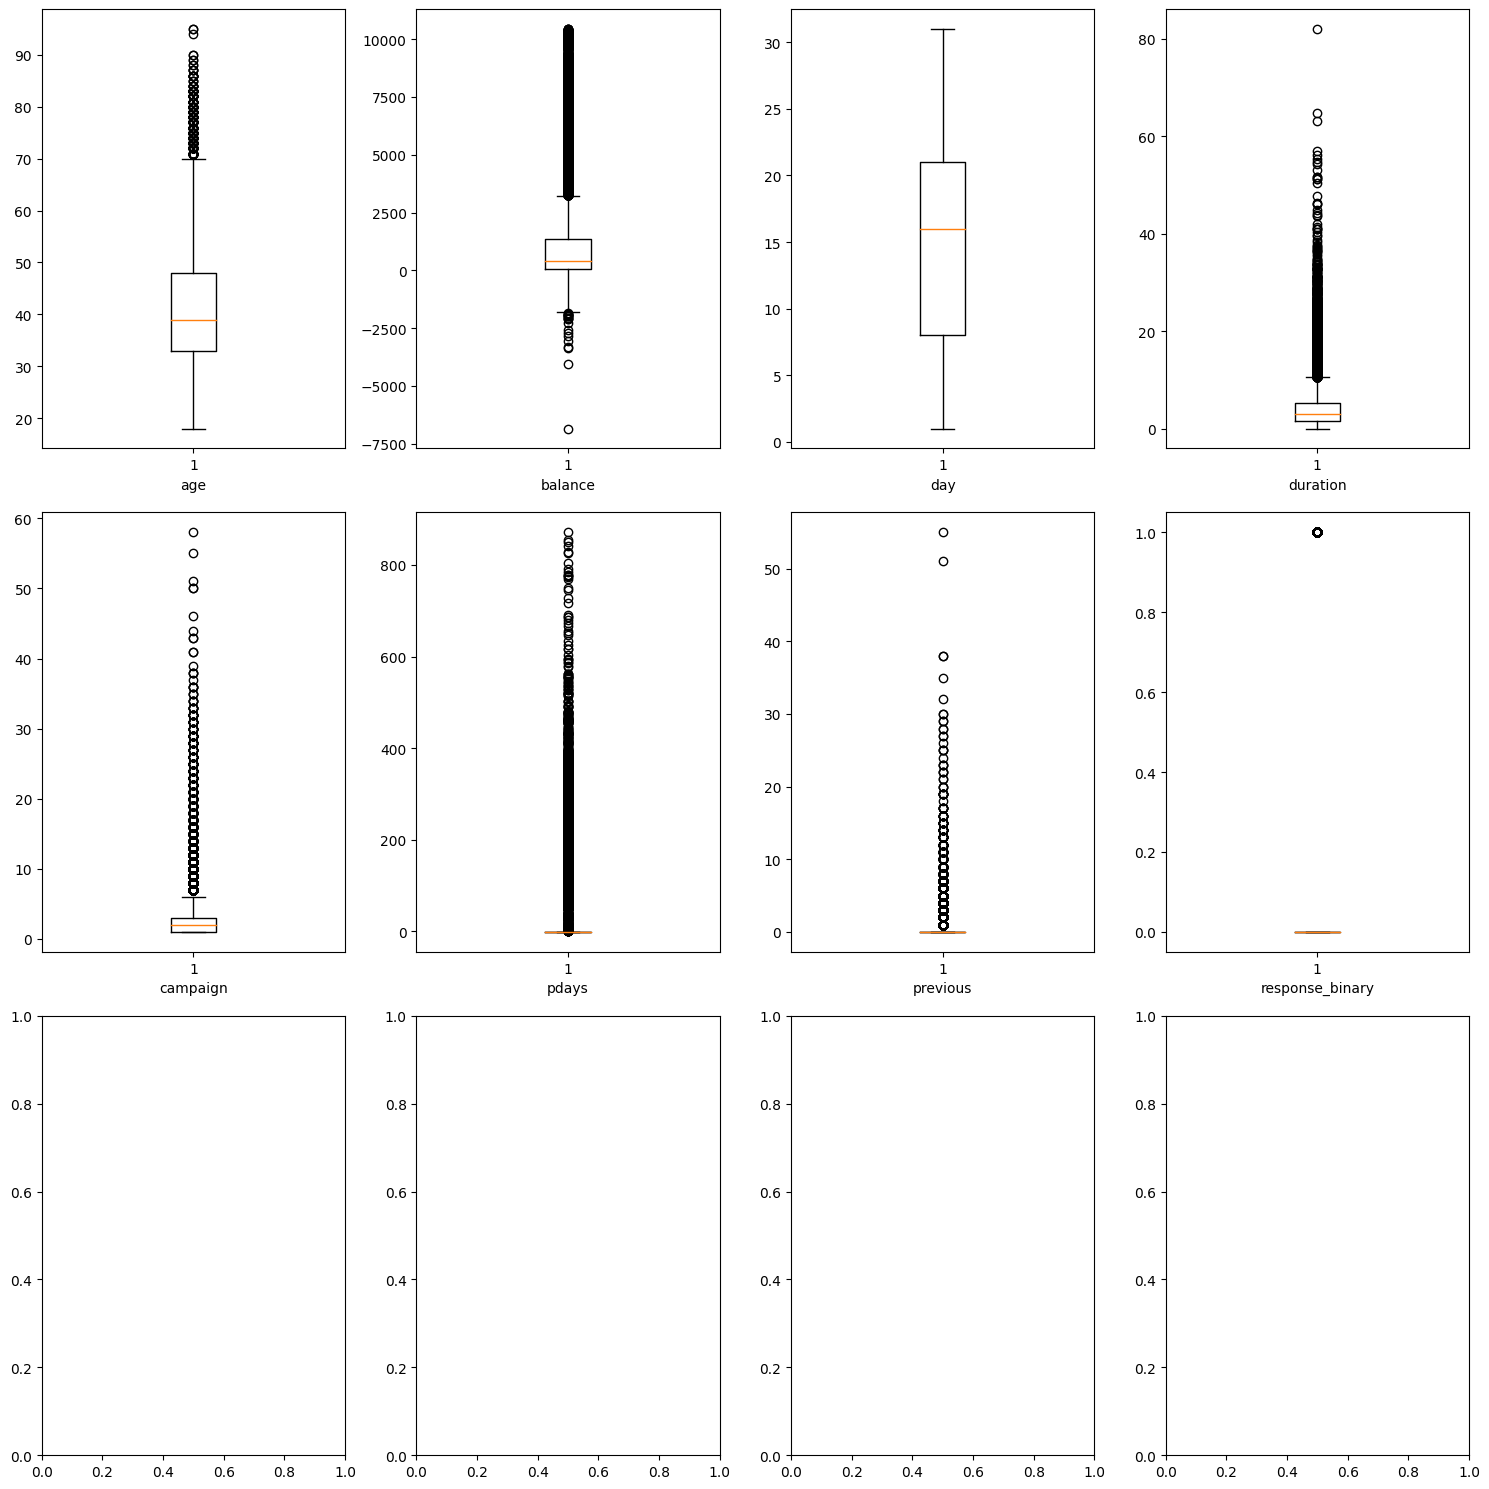

In [26]:
size=len(liste_float_int)
fig, axes = plt.subplots((size//4)+1, 4, figsize=(15, 15))
axes=axes.flatten()
for i, cols in enumerate(liste_float_int):
  axes[i].boxplot(df[cols])
  axes[i].set_xlabel(cols)
plt.tight_layout()
plt.show()
resume=summary(resume,"EDA","Box plot sur les champs numériques","Box plot sur les champs numériques")

28


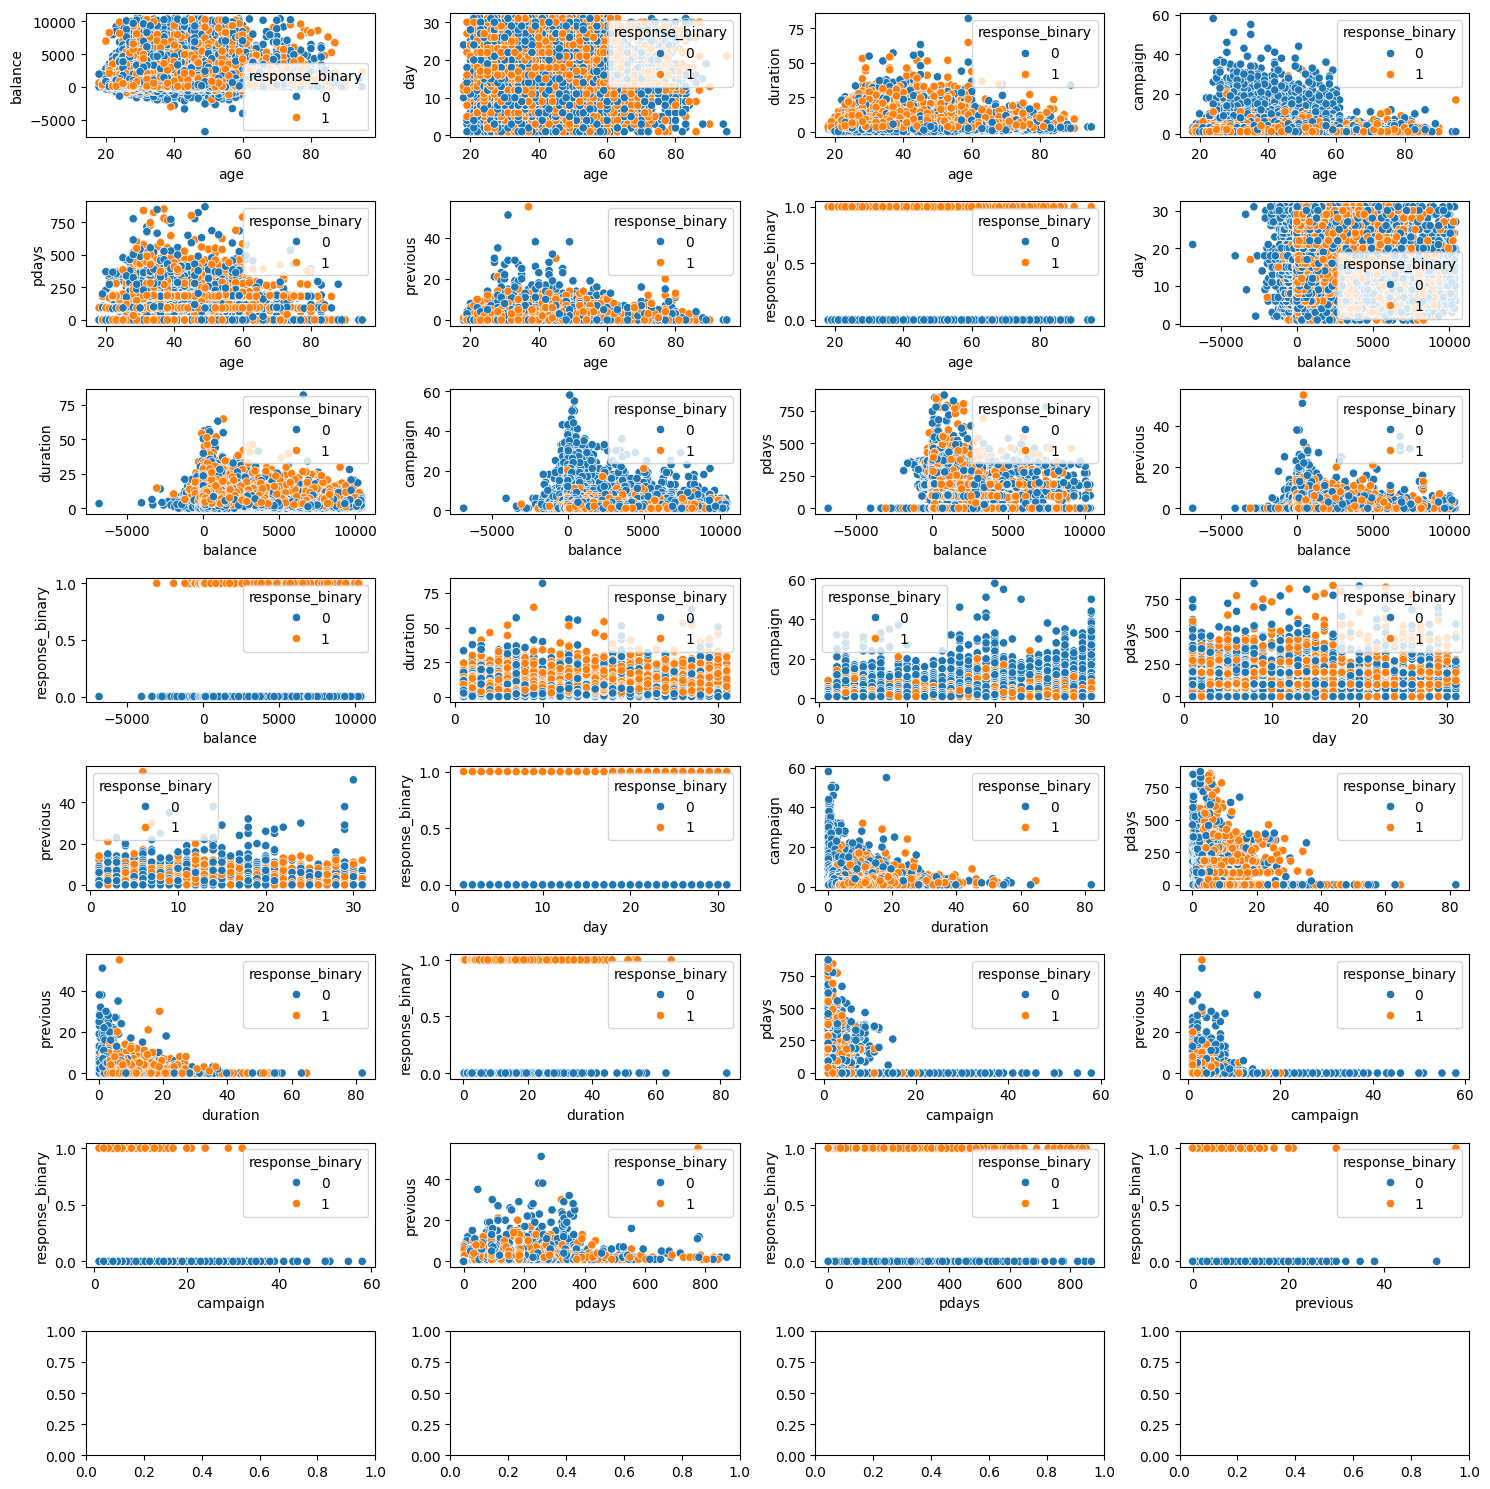

In [27]:
size=len(list(combinations(liste_float_int,2)))
print(size)
fig, axes = plt.subplots(max(size//4,1)+1, 4, figsize=(15, 15))
axes=axes.flatten()
for i, cols in enumerate(combinations(liste_float_int,2)):
  #print(1)
  sns.scatterplot(data=df,x=cols[0],y=cols[1],hue=cible,ax=axes[i])
   #axes[i].scatter(df[cols[0]], df[cols[1]])
   #axes[i].set_xlabel(cols[0])
   #axes[i].set_ylabel(cols[1])
plt.tight_layout()
plt.show()
resume=summary(resume,"EDA","sns Scatter plot avec hue sur la cible","sns Scatter plot avec hue sur la cible")

**Analyse VIF**

**Vérifications des valeurs abérantes**

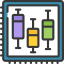

In [28]:
outliers=""
for col in liste_float_int:
  if df[col].nunique()>=5:
    inf=df[col].quantile(0.25)-1.5*iqr(df[col])
    sup=df[col].quantile(0.75)+1.5*iqr(df[col])
    df_outliers=df[(df[col]<inf) | (df[col]>sup)][col]
    outliers=outliers + "la colonne " + col + " contient "+ str(len(df_outliers))+ " outliers pour un iqr de " + str(iqr(df[col])) +'\n'
    df[col]=np.where(df[col]>sup,df[col].mean(),df[col])
    df[col]=np.where(df[col]<inf,df[col].mean(),df[col])
    print(df_outliers)
    print("*"*100)
resume=summary(resume,"EDA","valeurs aberantes avant correction",f"valeurs abérantes :"+"\n" + str(outliers))

27220    83
27309    75
27311    75
27361    83
27821    75
         ..
40798    71
40823    75
40835    73
40838    71
40839    72
Name: age, Length: 394, dtype: int64
****************************************************************************************************
55       6530
59       5935
166      4080
183      5699
214      3237
         ... 
40813    3409
40814    6879
40818    4256
40823    3810
40839    5715
Name: balance, Length: 4031, dtype: int64
****************************************************************************************************
Series([], Name: day, dtype: int64)
****************************************************************************************************
32       27.77
37       24.87
46       13.12
50       29.63
52       13.53
         ...  
40745    11.93
40769    11.68
40831    25.93
40837    16.28
40839    18.78
Name: duration, Length: 2970, dtype: float64
**************************************************************************************

In [29]:
outliers=""
for col in liste_float_int:
  if df[col].nunique()>=5:
    inf=df[col].quantile(0.25)-1.5*iqr(df[col])
    sup=df[col].quantile(0.75)+1.5*iqr(df[col])
    df[col]=np.where(df[col]>sup,sup,df[col])
    df[col]=np.where(df[col]<inf,inf,df[col])
    df_outliers=df[(df[col]<inf) | (df[col]>sup)][col]

    if len(df_outliers)>0:
      outliers= outliers + "la colonne " + col + " contient encore  "+ str(len(df_outliers))+ " outliers pour un iqr de " + str(iqr(df[col])) +'\n'
      print(df_outliers)
      print("*"*100)

resume=summary(resume,"EDA","valeurs aberantes après correction",f"valeurs abérantes :"+"\n" + str(outliers))

**Transformation des données catégorielles**

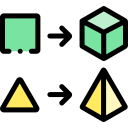

In [30]:
features=df.drop(cible, axis=1)
features=pd.get_dummies(features,columns=liste_cat,dtype=float, drop_first=True)
resume=summary(resume,"Data Preprocessing","transformation des données catégorielles",f"méthode utilisée: pd.get_dummies(...)")

**Division du Dataset**

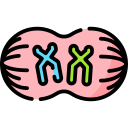

In [31]:
features=features.values
targets=df[cible].values
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=fraction, random_state=seed)
resume=summary(resume,"Modelisation",f"Division en données {features.shape} d'entrainement et de test \n",f"proportion de test {X_test.shape} :{fraction}"+"\n"\
               + f"valeur de reproductibilité :{seed}")

**Standardisation / Normalisation des données**

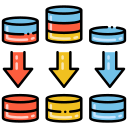

In [32]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
resume=summary(resume,"Data Preprocessing","Standardisation/Normalisation des données",f"méthode utilisée [sklearn]: StandardScaler(...)")

**Initialisation du modèle**

**Entrainement du modèle**

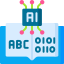

In [33]:
eval="selon la classification: 0 (positif) et 1 (négatif) \n \
L'utilisation des métriques d'évaluation dépend à la fois de l'équilibre dans les labels de classification \n\
et du coût des erreurs ; est-il plus coûteux d'obtenir des FP faux positifs ? est-il plus coûteux d'obtenir des FN faux négatifs?\n\
si on souhaite éviter des faux positifs (classer par erreur des 1 en 0) alors on privilégie la precision.\n\
si on souhaite éviter des faux négatifs (classer par erreur des 0 en 1) alors on privilégie le recall.\n\
s'il les deux types d'erreurs présentent le même coût alors on privilégie le f1-score (qui est réalité une moyenne hormonique de la precision et du recall).\n\
le ROC-AUC permet de voir comment le modèle évolue dans la classification en fonction de l'application d'un taux de seuil probabiliste croissant. \n\
Ces taux de seuils probabilistes sont les différentes probabilités de classification produites par le model"

resume=summary(resume,"Modelisation","les règles d'évaluation",eval)

In [34]:
if len(modeles)>1:
  resume=summary(resume,"Modelisation",f"Analyses comparative de {len(modeles)} modèles","")
if validation_croisee==False:
  resume=summary(resume,"Modelisation","SANS Validation croisée","")
else:
  resume=summary(resume,"Modelisation","AVEC Validation croisée","")

evaluations=""
for nom, modele in modeles.items():
  if validation_croisee==False:
    modele.fit(X_train,y_train)
    resume=summary(resume,"Modelisation","Entrainement du modèle",modele)
    y_pred=modele.predict(X_test)
    y_pred_proba=modele.predict_proba(X_test)[:,1]
    predictions.append((nom,y_pred,y_pred_proba))
  else:
    grid_search = GridSearchCV(modele, modeles_grid[nom], cv=fold, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train,y_train)
    resume=summary(resume,"Modelisation","paramètres du meilleur modèle", str(nom) +" : "+ str(grid_search.best_params_))
    y_pred=grid_search.predict(X_test)
    y_pred_proba=grid_search.predict_proba(X_test)[:,1]
    predictions.append((nom,y_pred,y_pred_proba))

  recall[nom]=recall_score(y_test,y_pred)
  precision[nom]=precision_score(y_test,y_pred)
  accuracy[nom]=accuracy_score(y_test,y_pred)
  f1score[nom]=f1_score(y_test,y_pred)

  evaluations=evaluations+ str(nom) +"  Recall "+str(round(recall[nom],3))+"\n"
  evaluations=evaluations+ str(nom) +"  F1-Score "+str(round(f1score[nom],3))+"\n"
  evaluations=evaluations+ str(nom) +"  Accuracy "+str(round(accuracy[nom],3))+"\n"
  evaluations=evaluations+ str(nom) +"  Precision "+str(round(precision[nom],3))+"\n"

resume=summary(resume,"Résultats","Analyse des scores",evaluations)

**Validation des hypothèses**

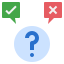

In [35]:
hypotheses="xxx"
resume=summary(resume,"Validation des hypothèses","Validation des hypothèses",hypotheses)

**Evaluation du modèle**

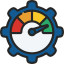

logreg


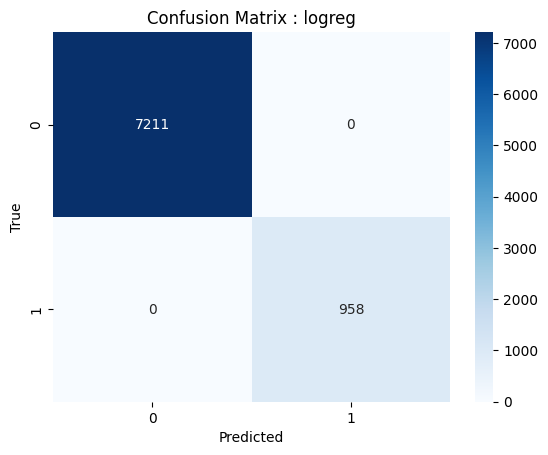

knn


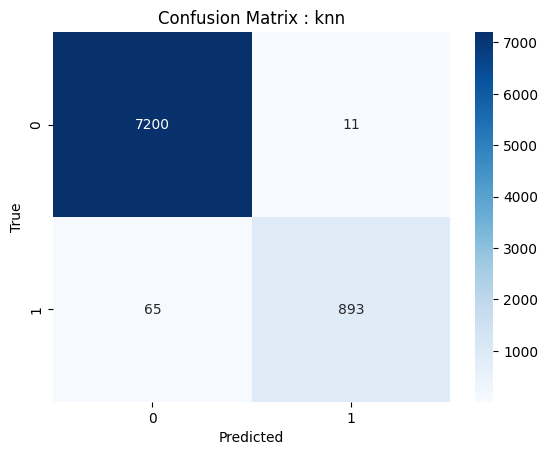

tree


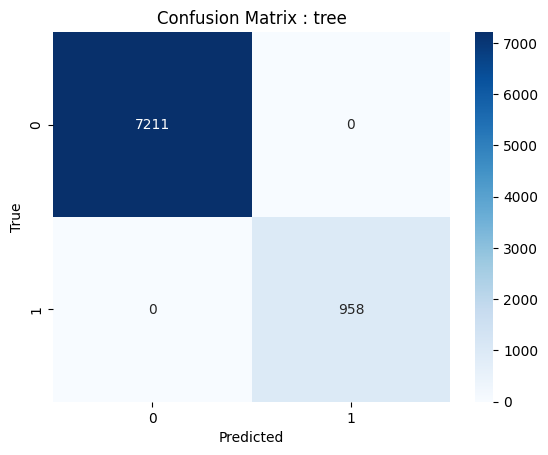

In [36]:
for val in predictions:
  print(val[0])
  cm = confusion_matrix(y_test, val[1])
  # Afficher la matrice de confusion avec seaborn
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.title('Confusion Matrix : '+ val[0])
  plt.show()
  resume=summary(resume,"Evaluation","Matrice de confusion : " + val[0],cm)


logreg


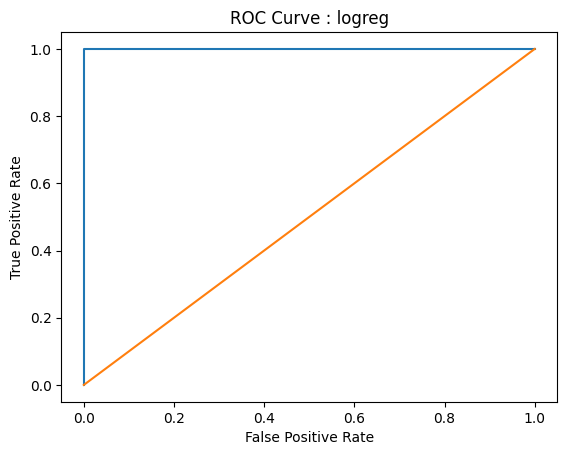

1.0
knn


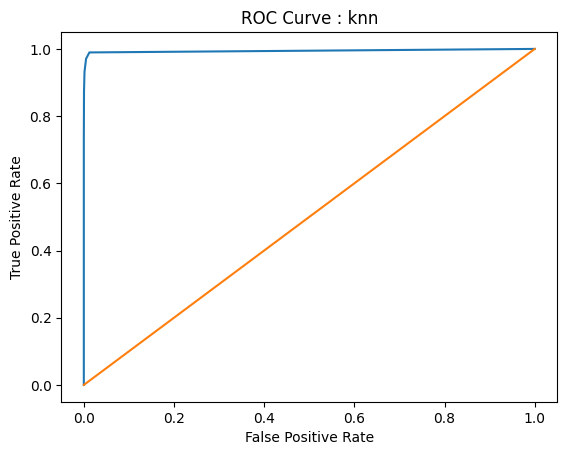

0.9943395021929209
tree


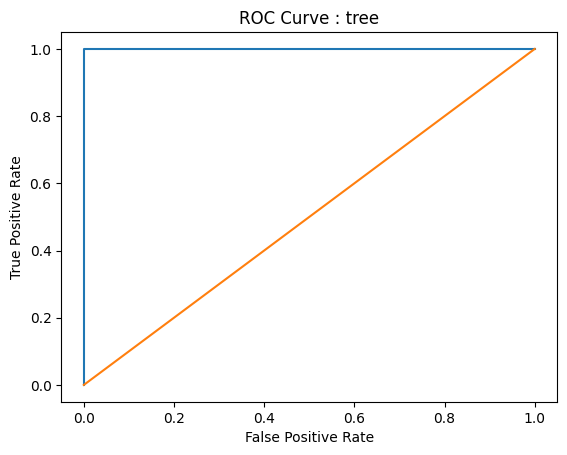

1.0


In [37]:
#print(y_pred)
#print(y_pred_proba)
for val in predictions:
  print(val[0])
  fpr, tpr, thresholds = roc_curve(y_test, val[2])
  plt.plot(fpr, tpr)
  plt.plot(np.arange(0,1.1,0.1), np.arange(0,1.1,0.1))
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC Curve : ' + val[0])
  plt.show()
  roc_auc = auc(fpr, tpr)
  print(roc_auc)
  resume=summary(resume,"Evaluation","Precision du modèle : " + val[0],str(round(roc_auc,3)))


Interpretation du résultat

In [38]:
resume=summary(resume,"Inteprétation du résultat","Interprétation :",f" notre modèle a un score de {str(round(roc_auc,3))} ce qui signifie que...")

**Rapport**

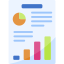

In [39]:
print_summary(resume)

****************************************************************************************************
================================RESULTATS: analyses et Modélisation=================================
****************************************************************************************************
+-----+---------------------------+-----------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------+
|   1 | Section                   | libelle                                                   | information                                                                                                                                                  |
+=====+===========================+===========================================================+============================================================================================